# 具体细节
+ 前两个阶段采用encoder-decoder结构学习多尺度文本信息，后一阶段在原始图像分辨率上学习，维持空间信息。
+ 每两个阶段之间使用SAM，强化前一阶段特征图
+ CSFF跨阶段特征融合机制，有效融合不同阶段之间的多尺度文本信息

# Layer

## CALayer 


<div align=center>
<img src=./img/CALayer.png />
</div>



H<sub>GP</sub>：全局池化操作

W<sub>d</sub>:卷积层的权重
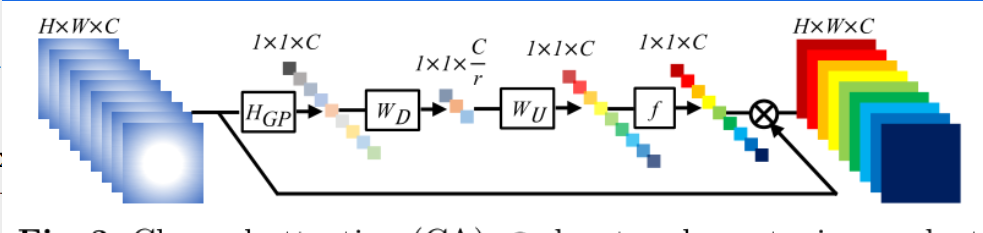

In [ ]:
class CALayer(nn.Module):
    def __init__(self, channel, reduction=16, bias=False):
        super(CALayer, self).__init__()
        # 对输入信号，提供2维的自适应平均池化操作。对于任何输入大小的输入，可以将输出尺寸指定为H * W，但是输入和输出特征的数目不会变化。
        # 特征转为点
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        # 特征进行先下采样然后上采样
        self.conv_du = nn.Sequential(
            nn.Conv2d(channel, channel // reduction, 1, padding=0, bias=bias),
            # 进行覆盖操作
            nn.ReLU(inplace=True),
            nn.Conv2d(channel // reduction, channel, 1, padding=0, bias=bias),
            nn.Sigmoid()
        )

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.conv_du(y)
        return x * y

参考文献：DOI: 10.1007/978-3-030-01234-2_18 《Image Super-Resolution Using Very Deep Residual Channel Attention Networks》
 
 **为什么提出CA？**

为了在从通道中获取更多有用的信息。通道之前的网络对于信道一视同仁，这对于实际情况来说不够灵活。为了使网络聚焦于更具信息性的特征，我们利用特征通道之间的相互依赖关系，产生了通道注意(CA)机制。

**如何为每个通道特征产生不同的关注度？**

<font color=red>这里我们主要关注两个问题：第一，LR空间中的信息具有丰富的低频成分和有价值的高频成分。低频部分似乎更平坦。高频成分通常是区域，充满边缘、纹理和其他细节。另一方面，卷积后的输出不能利用局部区域之外的上下文信息。在这些分析的基础上，我们利用全局平均池将通道的全局空间信息作为通道描述符。</font>

为了通过全局平均池从聚合信息中完全捕获通道依赖关系，我们引入了一种门控机制。

我觉得这一步是做通道清洗，增强某些通道信息。

## CAB 

<div align=center>
<img src=./img/CAB.png />
</div>


In [ ]:
class CAB(nn.Module):
    # n_feat:输入输出通道
    # kernel_size:卷积核大小
    # reduction:
    # bias: T or F?
    # act:在MPRNet中是 nn.PReLU()
    def __init__(self, n_feat, kernel_size, reduction, bias, act):
        super(CAB, self).__init__()
        modules_body = []
        modules_body.append(conv(n_feat, n_feat, kernel_size, bias=bias))
        modules_body.append(act)
        modules_body.append(conv(n_feat, n_feat, kernel_size, bias=bias))
        self.CA = CALayer(n_feat, reduction, bias=bias)
        self.body = nn.Sequential(*modules_body)

    def forward(self, x):
        res = self.body(x)
        res = self.CA(res)
        res += x
        return res

为了更好地提取图像特征

## SAM

<div align=center>
<img src=./img/SAM.png />
</div>

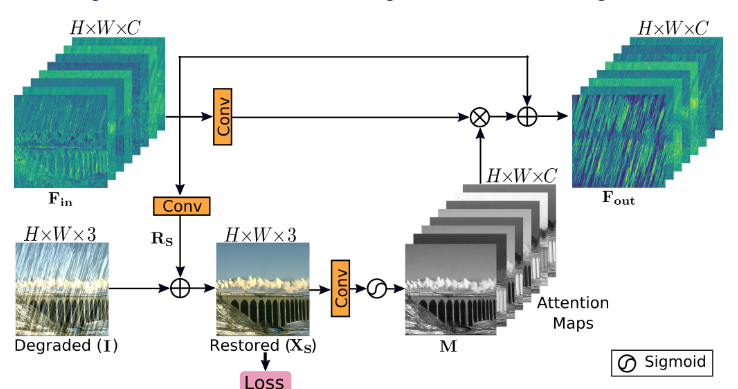

In [ ]:
class SAM(nn.Module):
    def __init__(self, n_feat, kernel_size, bias):
        super(SAM, self).__init__()
        self.conv1 = conv(n_feat, n_feat, kernel_size, bias=bias)
        self.conv2 = conv(n_feat, 3, kernel_size, bias=bias)
        self.conv3 = conv(3, n_feat, kernel_size, bias=bias)

    # x1：进入下一阶段
    # img用来生成本阶段图像
    def forward(self, x, x_img):
        x1 = self.conv1(x)
        img = self.conv2(x) + x_img
        x2 = torch.sigmoid(self.conv3(img))
        x1 = x1 * x2
        x1 = x1 + x
        return x1, img

在局部监督预测的帮助下，我们生成关注图来抑制当前阶段信息量较少的特征，而只允许有用的特征传播到下一阶段

## Encoder

In [ ]:
class Encoder(nn.Module):
    # act:nn.PReLU()
    # scale_unetfeats:48 注意：feat
    def __init__(self, n_feat, kernel_size, reduction, act, bias, scale_unetfeats, csff):
        super(Encoder, self).__init__()

        
        # 译码器阶段一：两个CAB
        # 输入通道：n_feat
        self.encoder_level1 = [CAB(n_feat, kernel_size, reduction, bias=bias, act=act) for _ in range(2)]

        # 阶段二：两个CAB
        # 输入通道改为n_feat + scale_unetfeats
        self.encoder_level2 = [CAB(n_feat + scale_unetfeats, kernel_size, reduction, bias=bias, act=act) for _ in
                               range(2)]
        # 阶段二：两个CAB
        # 输入通道改为n_feat + scale_unetfeats*2
        self.encoder_level3 = [CAB(n_feat + (scale_unetfeats * 2), kernel_size, reduction, bias=bias, act=act) for _ in
                               range(2)]

        self.encoder_level1 = nn.Sequential(*self.encoder_level1)
        self.encoder_level2 = nn.Sequential(*self.encoder_level2)
        self.encoder_level3 = nn.Sequential(*self.encoder_level3)

        self.down12 = DownSample(n_feat, scale_unetfeats)
        self.down23 = DownSample(n_feat + scale_unetfeats, scale_unetfeats)

        # 跨阶段融合(CSFF)
        # 个人理解：跨阶段融合其实是将前一阶段的feat和res与本阶段的cat一起输入encoder中，详情可以看流程图
        # feat是译码器输出
        # res是解码器输出
        if csff:
            self.csff_enc1 = nn.Conv2d(n_feat, n_feat, kernel_size=1, bias=bias)
            self.csff_enc2 = nn.Conv2d(n_feat + scale_unetfeats, n_feat + scale_unetfeats, kernel_size=1, bias=bias)
            self.csff_enc3 = nn.Conv2d(n_feat + (scale_unetfeats * 2), n_feat + (scale_unetfeats * 2), kernel_size=1,
                                       bias=bias)

            self.csff_dec1 = nn.Conv2d(n_feat, n_feat, kernel_size=1, bias=bias)
            self.csff_dec2 = nn.Conv2d(n_feat + scale_unetfeats, n_feat + scale_unetfeats, kernel_size=1, bias=bias)
            self.csff_dec3 = nn.Conv2d(n_feat + (scale_unetfeats * 2), n_feat + (scale_unetfeats * 2), kernel_size=1,
                                       bias=bias)

    # encoder_out：前一阶段译码器输出
    # decoder_out：前一阶段解码器输出
    # enc1：进入下一阶段即SAM12
    # 在跨阶段融合中使用enc1、2、3
    def forward(self, x, encoder_outs=None, decoder_outs=None):
        enc1 = self.encoder_level1(x)
        if (encoder_outs is not None) and (decoder_outs is not None):
            enc1 = enc1 + self.csff_enc1(encoder_outs[0]) + self.csff_dec1(decoder_outs[0])

        x = self.down12(enc1)

        enc2 = self.encoder_level2(x)
        if (encoder_outs is not None) and (decoder_outs is not None):
            enc2 = enc2 + self.csff_enc2(encoder_outs[1]) + self.csff_dec2(decoder_outs[1])

        x = self.down23(enc2)

        enc3 = self.encoder_level3(x)
        if (encoder_outs is not None) and (decoder_outs is not None):
            enc3 = enc3 + self.csff_enc3(encoder_outs[2]) + self.csff_dec3(decoder_outs[2])

        return [enc1, enc2, enc3]

## Decoder 

In [ ]:
class Decoder(nn.Module):
    def __init__(self, n_feat, kernel_size, reduction, act, bias, scale_unetfeats):
        super(Decoder, self).__init__()

        self.decoder_level1 = [CAB(n_feat, kernel_size, reduction, bias=bias, act=act) for _ in range(2)]
        self.decoder_level2 = [CAB(n_feat + scale_unetfeats, kernel_size, reduction, bias=bias, act=act) for _ in
                               range(2)]
        self.decoder_level3 = [CAB(n_feat + (scale_unetfeats * 2), kernel_size, reduction, bias=bias, act=act) for _ in
                               range(2)]

        self.decoder_level1 = nn.Sequential(*self.decoder_level1)
        self.decoder_level2 = nn.Sequential(*self.decoder_level2)
        self.decoder_level3 = nn.Sequential(*self.decoder_level3)

        self.skip_attn1 = CAB(n_feat, kernel_size, reduction, bias=bias, act=act)
        self.skip_attn2 = CAB(n_feat + scale_unetfeats, kernel_size, reduction, bias=bias, act=act)
        
        #n_feat:输入通道
        #scale_unetfeats:放缩倍数
        self.up21 = SkipUpSample(n_feat, scale_unetfeats)
        self.up32 = SkipUpSample(n_feat + scale_unetfeats, scale_unetfeats)

    def forward(self, outs):
        enc1, enc2, enc3 = outs
        dec3 = self.decoder_level3(enc3)

        x = self.up32(dec3, self.skip_attn2(enc2))
        dec2 = self.decoder_level2(x)

        x = self.up21(dec2, self.skip_attn1(enc1))
        dec1 = self.decoder_level1(x)

        return [dec1, dec2, dec3]

<font color=red>为什么要进行放缩?</font>

可以不用降采样，降采样是手段不是目的！！(可参考下文的HighRes3DNet)降采样有以下几个目的:

1.降低显存和计算量，图小了占内存也就小了，运算量也少了。

2.增大感受野，使同样3*3的卷积能在更大的图像范围上进行特征提取。大感受野对分割任务很重要，小感受野是做不了多类分割的，而且分割出来的掩膜边界很粗糙！！

3.多出几条不同程度下采样的分支，可以很方便进行多尺度特征的融合。多级语义融合会让分类很准。如果不需要考虑计算和显存，你当然可以不做下采样，用膨胀卷积也是可以增大感受野的。

大家可能觉得做了下采样，会导致底层特征损失，但只要留下一条没有做下采样的分支，底层特征就不会损失。所以unet提出用skip connection保留细节。

进阶目的是，如何保证各尺度信息变换充分。

作者：张良怀
链接：https://www.zhihu.com/question/322191738/answer/668729190
来源：知乎
著作权归作者所有。商业转载请联系作者获得授权，非商业转载请注明出处。


## ORSNet 

<div align=center>
<img src=./img/ORB.png />
</div>

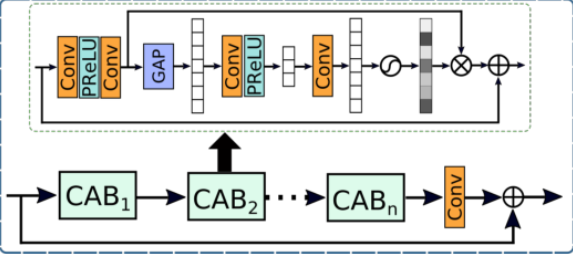

In [ ]:
class ORB(nn.Module):
    def __init__(self, n_feat, kernel_size, reduction, act, bias, num_cab):
        super(ORB, self).__init__()
        modules_body = []
        modules_body = [CAB(n_feat, kernel_size, reduction, bias=bias, act=act) for _ in range(num_cab)]
        modules_body.append(conv(n_feat, n_feat, kernel_size))
        self.body = nn.Sequential(*modules_body)

    def forward(self, x):
        res = self.body(x)
        res += x
        return res


class ORSNet(nn.Module):
    def __init__(self, n_feat, scale_orsnetfeats, kernel_size, reduction, act, bias, scale_unetfeats, num_cab):
        super(ORSNet, self).__init__()

        self.orb1 = ORB(n_feat + scale_orsnetfeats, kernel_size, reduction, act, bias, num_cab)
        self.orb2 = ORB(n_feat + scale_orsnetfeats, kernel_size, reduction, act, bias, num_cab)
        self.orb3 = ORB(n_feat + scale_orsnetfeats, kernel_size, reduction, act, bias, num_cab)

        self.up_enc1 = UpSample(n_feat, scale_unetfeats)
        self.up_dec1 = UpSample(n_feat, scale_unetfeats)

        self.up_enc2 = nn.Sequential(UpSample(n_feat + scale_unetfeats, scale_unetfeats),
                                     UpSample(n_feat, scale_unetfeats))
        self.up_dec2 = nn.Sequential(UpSample(n_feat + scale_unetfeats, scale_unetfeats),
                                     UpSample(n_feat, scale_unetfeats))

        self.conv_enc1 = nn.Conv2d(n_feat, n_feat + scale_orsnetfeats, kernel_size=1, bias=bias)
        self.conv_enc2 = nn.Conv2d(n_feat, n_feat + scale_orsnetfeats, kernel_size=1, bias=bias)
        self.conv_enc3 = nn.Conv2d(n_feat, n_feat + scale_orsnetfeats, kernel_size=1, bias=bias)

        self.conv_dec1 = nn.Conv2d(n_feat, n_feat + scale_orsnetfeats, kernel_size=1, bias=bias)
        self.conv_dec2 = nn.Conv2d(n_feat, n_feat + scale_orsnetfeats, kernel_size=1, bias=bias)
        self.conv_dec3 = nn.Conv2d(n_feat, n_feat + scale_orsnetfeats, kernel_size=1, bias=bias)

    def forward(self, x, encoder_outs, decoder_outs):
        x = self.orb1(x)
        x = x + self.conv_enc1(encoder_outs[0]) + self.conv_dec1(decoder_outs[0])

        x = self.orb2(x)
        x = x + self.conv_enc2(self.up_enc1(encoder_outs[1])) + self.conv_dec2(self.up_dec1(decoder_outs[1]))

        x = self.orb3(x)
        x = x + self.conv_enc3(self.up_enc2(encoder_outs[2])) + self.conv_dec3(self.up_dec2(decoder_outs[2]))

        return x

# MPRNet

<div align=center>
<img src=./img/MPRNet.png />
</div>

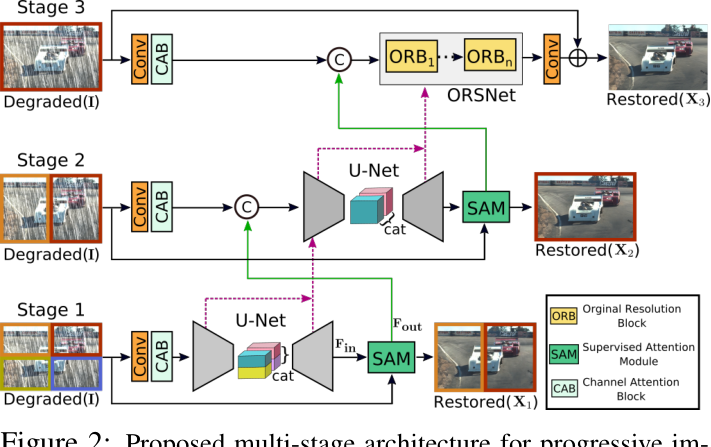

In [ ]:
class MPRNet(nn.Module):
    def __init__(self, in_c=3, out_c=3, n_feat=96, scale_unetfeats=48, scale_orsnetfeats=32, num_cab=8, kernel_size=3,
                 reduction=4, bias=False):
        super(MPRNet, self).__init__()

        act = nn.PReLU()
        # 阶段一
        self.shallow_feat1 = nn.Sequential(conv(in_c, n_feat, kernel_size, bias=bias),
                                           CAB(n_feat, kernel_size, reduction, bias=bias, act=act))
        # 初始阶段不需要跨阶段特征融合
        # 返回有三个参数
        self.stage1_encoder = Encoder(n_feat, kernel_size, reduction, act, bias, scale_unetfeats, csff=False)
        self.stage1_decoder = Decoder(n_feat, kernel_size, reduction, act, bias, scale_unetfeats)
        self.sam12 = SAM(n_feat, kernel_size=1, bias=bias)
        self.concat12 = conv(n_feat * 2, n_feat, kernel_size, bias=bias)
        # 阶段二
        self.shallow_feat2 = nn.Sequential(conv(in_c, n_feat, kernel_size, bias=bias),
                                           CAB(n_feat, kernel_size, reduction, bias=bias, act=act))
        # 与第一个阶段的代码进行特征融合
        self.stage2_encoder = Encoder(n_feat, kernel_size, reduction, act, bias, scale_unetfeats, csff=True)
        self.stage2_decoder = Decoder(n_feat, kernel_size, reduction, act, bias, scale_unetfeats)

        self.sam23 = SAM(n_feat, kernel_size=1, bias=bias)
        self.shallow_feat3 = nn.Sequential(conv(in_c, n_feat, kernel_size, bias=bias),
                                           CAB(n_feat, kernel_size, reduction, bias=bias, act=act))
        self.sam23 = SAM(n_feat, kernel_size=1, bias=bias)
        self.concat23 = conv(n_feat * 2, n_feat + scale_orsnetfeats, kernel_size, bias=bias)
        # 阶段三
        self.stage3_orsnet = ORSNet(n_feat, scale_orsnetfeats, kernel_size, reduction, act, bias, scale_unetfeats,
                                    num_cab)
        self.tail = conv(n_feat + scale_orsnetfeats, out_c, kernel_size, bias=bias)

    def forward(self, x3_img):
        # 获取图像尺寸用来分割
        H = x3_img.size(2)
        W = x3_img.size(3)

        # 分割图片
        # Two Patches for Stage 2
        x2top_img = x3_img[:, :, 0:int(H / 2), :]
        x2bot_img = x3_img[:, :, int(H / 2):H, :]

        # Four Patches for Stage 1
        x1ltop_img = x2top_img[:, :, :, 0:int(W / 2)]
        x1rtop_img = x2top_img[:, :, :, int(W / 2):W]
        x1lbot_img = x2bot_img[:, :, :, 0:int(W / 2)]
        x1rbot_img = x2bot_img[:, :, :, int(W / 2):W]

        ##-------------------------------------------
        ##-------------- Stage 1---------------------
        ##-------------------------------------------

        # 计算表面特征
        x1ltop = self.shallow_feat1(x1ltop_img)
        x1rtop = self.shallow_feat1(x1rtop_img)
        x1lbot = self.shallow_feat1(x1lbot_img)
        x1rbot = self.shallow_feat1(x1rbot_img)

        # 四块图像进行译码操作
        feat1_ltop = self.stage1_encoder(x1ltop)
        feat1_rtop = self.stage1_encoder(x1rtop)
        feat1_lbot = self.stage1_encoder(x1lbot)
        feat1_rbot = self.stage1_encoder(x1rbot)

        # 拼合深层特征，拼合后成为上下两块
        feat1_top = [torch.cat((k, v), 3) for k, v in zip(feat1_ltop, feat1_rtop)]
        feat1_bot = [torch.cat((k, v), 3) for k, v in zip(feat1_lbot, feat1_rbot)]

        # Pass features through Decoder of Stage 1
        res1_top = self.stage1_decoder(feat1_top)
        res1_bot = self.stage1_decoder(feat1_bot)

        ## 使用SAM
        x2top_samfeats, stage1_img_top = self.sam12(res1_top[0], x2top_img)
        x2bot_samfeats, stage1_img_bot = self.sam12(res1_bot[0], x2bot_img)

        # 获取阶段一的图像
        stage1_img = torch.cat([stage1_img_top, stage1_img_bot], 2)

        ##-------------------------------------------
        ##-------------- Stage 2---------------------
        ##-------------------------------------------
        ## 计算表层特征
        x2top = self.shallow_feat2(x2top_img)
        x2bot = self.shallow_feat2(x2bot_img)

        # 连接阶段1的SAM特征和阶段2的表层特征，通道融合
        ## Concatenate SAM features of Stage 1 with shallow features of Stage 2
        x2top_cat = self.concat12(torch.cat([x2top, x2top_samfeats], 1))
        x2bot_cat = self.concat12(torch.cat([x2bot, x2bot_samfeats], 1))

        ## Process features of both patches with Encoder of Stage 2
        feat2_top = self.stage2_encoder(x2top_cat, feat1_top, res1_top)
        feat2_bot = self.stage2_encoder(x2bot_cat, feat1_bot, res1_bot)

        ## 连接深层特征
        feat2 = [torch.cat((k, v), 2) for k, v in zip(feat2_top, feat2_bot)]

        ## Pass features through Decoder of Stage 2
        res2 = self.stage2_decoder(feat2)

        ## 使用SAM
        x3_samfeats, stage2_img = self.sam23(res2[0], x3_img)

        ##-------------------------------------------
        ##-------------- Stage 3---------------------
        ##-------------------------------------------
        ## 计算表层特征
        x3 = self.shallow_feat3(x3_img)

        ## Concatenate SAM features of Stage 2 with shallow features of Stage 3
        x3_cat = self.concat23(torch.cat([x3, x3_samfeats], 1))

        x3_cat = self.stage3_orsnet(x3_cat, feat2, res2)

        stage3_img = self.tail(x3_cat)

        return [stage3_img + x3_img] if not self.training else [stage3_img + x3_img, stage2_img, stage1_img]


训练时遇到的问题：
训练过程中模型很早收敛但模型效果很差。猜测原因：没有加normalization层。作者解释的原因：增加normalization层会降低模型表现，只能通过降低学习率来控制。